In [1]:
import datetime as dt
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam, Adamax, RMSprop

Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)

In [3]:
# load data
df_orig = pd.read_json("../datasets/df.json", orient='split')
df = df_orig.copy()
df = df[df.eth_close.isnull().sum():]
df.fillna(0, inplace=True)
df.set_index("date", drop=True, inplace=True)

In [4]:
ts = pd.DataFrame(df.eth_close.copy())

scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts.values)
ts_df = pd.DataFrame(ts_scaled).set_index(df.index.values)
ts_df.columns = ['original']
print(ts_df.shape)
ts_df.head(3)

(1134, 1)


,original
2015-08-06,0.001863
2015-08-07,0.000563
2015-08-08,0.000563


In [5]:
def shift_data(df, window_size):
    # shift data
    data_shifted = df.copy()
    for i in range(window_size):
        df = pd.concat([df, data_shifted.shift(-(i+1))], axis=1)

        df.dropna(axis=0, inplace=True)
    # rename columns
    cols = list(df.columns)[1:]
    for i, col in enumerate(cols):
        cols[i] = 'shift -{}'.format(i+1)
    
    cols = [df.columns[0]] + cols
    df.columns = cols
    return df

In [6]:
ts_df = shift_data(ts_df, 30)
print(ts_df.shape)
ts_df.head(3)

(1104, 31)


,original,shift -1,shift -2,shift -3,shift -4,shift -5,shift -6,shift -7,shift -8,shift -9,...,shift -21,shift -22,shift -23,shift -24,shift -25,shift -26,shift -27,shift -28,shift -29,shift -30
2015-08-06,0.001863,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,...,0.000636,0.000549,0.000650,0.000643,0.000679,0.000520,0.000585,0.000672,0.000686,0.000664
2015-08-07,0.000563,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,0.000636,...,0.000549,0.000650,0.000643,0.000679,0.000520,0.000585,0.000672,0.000686,0.000664,0.000621
2015-08-08,0.000563,0.000563,0.000412,0.000628,0.001054,0.000989,0.000989,0.000686,0.000636,0.000679,...,0.000650,0.000643,0.000679,0.000520,0.000585,0.000672,0.000686,0.000664,0.000621,0.000607


In [14]:
train = ts_df[:-30]
test = ts_df[-30:]

X_train, X_test = train.iloc[:, :-1], test.iloc[:,:-1]
y_train, y_test = train.iloc[:, -1], test.iloc[:, -1]

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1074, 30) (1074,)
(30, 30) (30,)


In [ ]:
# Reshape for LSTM: 3d array (num_samples, num_time_steps, num_features)
#def prep_data(data):
#    data_reshaped = np.reshape(data, (data.shape[0], data.shape[1], 1))
#    return data_reshaped

#def lstm_data(data, window_size):
#    data_reshaped = np.reshape(data, (data.shape[0], window_size, 1))
#    return data_reshaped

In [18]:
X_train = np.array(X_train).reshape(X_train.shape[0], 30, 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 30, 1)
print(X_train.shape, X_test.shape)

(1074, 30, 1) (30, 30, 1)


In [41]:
def build_lstm(X_train, y_train):
    model = Sequential()
    model.add(LSTM(
        units=1,
        activation='tanh',
        use_bias=True,
        input_shape=(X_train.shape[1], X_train.shape[2])))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005))
    return model

In [43]:
lstm = build_lstm(X_train, y_train)
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
start = time.time()
lstm.fit(X_train, y_train, epochs=500, validation_split=0.1)
print('runtime: {}'.format(time.time() - start))

Train on 966 samples, validate on 108 samples
Epoch 1/500
966/966 [==============================] - 1s 1ms/step - loss: 0.1070 - val_loss: 0.2333
Epoch 2/500
966/966 [==============================] - 1s 801us/step - loss: 0.0815 - val_loss: 0.1774
Epoch 3/500
966/966 [==============================] - 1s 696us/step - loss: 0.0696 - val_loss: 0.1478
Epoch 4/500
966/966 [==============================] - 1s 727us/step - loss: 0.0627 - val_loss: 0.1290
Epoch 5/500
966/966 [==============================] - 1s 708us/step - loss: 0.0582 - val_loss: 0.1163
Epoch 6/500
966/966 [==============================] - 1s 725us/step - loss: 0.0547 - val_loss: 0.1050
Epoch 7/500
966/966 [==============================] - 1s 727us/step - loss: 0.0514 - val_loss: 0.0970
Epoch 8/500
966/966 [==============================] - 1s 778us/step - loss: 0.0484 - val_loss: 0.0867
Epoch 9/500
966/966 [==============================] - 1s 736us/step - loss: 0.0452 - val_loss: 0.0785
Epoch 10/500
966/966 [=======

966/966 [==============================] - 1s 713us/step - loss: 5.4199e-04 - val_loss: 0.0013
Epoch 79/500
966/966 [==============================] - 1s 711us/step - loss: 5.4185e-04 - val_loss: 9.7314e-04
Epoch 80/500
966/966 [==============================] - 1s 711us/step - loss: 5.2829e-04 - val_loss: 0.0012
Epoch 81/500
966/966 [==============================] - 1s 706us/step - loss: 5.0899e-04 - val_loss: 9.6968e-04
Epoch 82/500
966/966 [==============================] - 1s 709us/step - loss: 5.0044e-04 - val_loss: 8.0502e-04
Epoch 83/500
966/966 [==============================] - 1s 702us/step - loss: 4.9175e-04 - val_loss: 8.4913e-04
Epoch 84/500
966/966 [==============================] - 1s 704us/step - loss: 4.7978e-04 - val_loss: 8.5579e-04
Epoch 85/500
966/966 [==============================] - 1s 676us/step - loss: 4.6952e-04 - val_loss: 7.7133e-04
Epoch 86/500
966/966 [==============================] - 1s 606us/step - loss: 4.5988e-04 - val_loss: 6.7458e-04
Epoch 87/500


Epoch 151/500
966/966 [==============================] - 1s 693us/step - loss: 3.1744e-04 - val_loss: 3.6633e-04
Epoch 152/500
966/966 [==============================] - 1s 701us/step - loss: 3.2145e-04 - val_loss: 3.3977e-04
Epoch 153/500
966/966 [==============================] - 1s 693us/step - loss: 3.2376e-04 - val_loss: 3.3972e-04
Epoch 154/500
966/966 [==============================] - 1s 704us/step - loss: 3.1720e-04 - val_loss: 3.3454e-04
Epoch 155/500
966/966 [==============================] - 1s 709us/step - loss: 3.1469e-04 - val_loss: 3.6134e-04
Epoch 156/500
966/966 [==============================] - 1s 705us/step - loss: 3.1724e-04 - val_loss: 3.5370e-04
Epoch 157/500
966/966 [==============================] - 1s 701us/step - loss: 3.1882e-04 - val_loss: 3.3742e-04
Epoch 158/500
966/966 [==============================] - 1s 701us/step - loss: 3.2123e-04 - val_loss: 3.3966e-04
Epoch 159/500
966/966 [==============================] - 1s 710us/step - loss: 3.1436e-04 - val_

966/966 [==============================] - 1s 701us/step - loss: 3.1464e-04 - val_loss: 3.3198e-04
Epoch 224/500
966/966 [==============================] - 1s 708us/step - loss: 3.0964e-04 - val_loss: 3.7051e-04
Epoch 225/500
966/966 [==============================] - 1s 716us/step - loss: 3.0956e-04 - val_loss: 3.3490e-04
Epoch 226/500
966/966 [==============================] - 1s 708us/step - loss: 3.1013e-04 - val_loss: 3.7113e-04
Epoch 227/500
966/966 [==============================] - 1s 710us/step - loss: 3.0721e-04 - val_loss: 3.3919e-04
Epoch 228/500
966/966 [==============================] - 1s 693us/step - loss: 3.0821e-04 - val_loss: 3.3825e-04
Epoch 229/500
966/966 [==============================] - 1s 716us/step - loss: 3.0747e-04 - val_loss: 3.5457e-04
Epoch 230/500
966/966 [==============================] - 1s 714us/step - loss: 3.0807e-04 - val_loss: 3.3652e-04
Epoch 231/500
966/966 [==============================] - 1s 706us/step - loss: 3.0943e-04 - val_loss: 3.2903e-

966/966 [==============================] - 1s 704us/step - loss: 3.0283e-04 - val_loss: 3.3547e-04
Epoch 296/500
966/966 [==============================] - 1s 699us/step - loss: 3.0588e-04 - val_loss: 3.3141e-04
Epoch 297/500
966/966 [==============================] - 1s 707us/step - loss: 3.0744e-04 - val_loss: 3.8307e-04
Epoch 298/500
966/966 [==============================] - 1s 705us/step - loss: 3.0944e-04 - val_loss: 3.4127e-04
Epoch 299/500
966/966 [==============================] - 1s 707us/step - loss: 3.0527e-04 - val_loss: 3.3904e-04
Epoch 300/500
966/966 [==============================] - 1s 708us/step - loss: 3.0366e-04 - val_loss: 3.4503e-04
Epoch 301/500
966/966 [==============================] - 1s 701us/step - loss: 3.0292e-04 - val_loss: 3.3376e-04
Epoch 302/500
966/966 [==============================] - 1s 707us/step - loss: 3.0390e-04 - val_loss: 3.5143e-04
Epoch 303/500
966/966 [==============================] - 1s 705us/step - loss: 3.0459e-04 - val_loss: 3.4215e-

966/966 [==============================] - 1s 710us/step - loss: 3.0227e-04 - val_loss: 3.2197e-04
Epoch 368/500
966/966 [==============================] - 1s 713us/step - loss: 2.9632e-04 - val_loss: 3.4451e-04
Epoch 369/500
966/966 [==============================] - 1s 708us/step - loss: 3.0023e-04 - val_loss: 3.3033e-04
Epoch 370/500
966/966 [==============================] - 1s 700us/step - loss: 2.9799e-04 - val_loss: 3.4363e-04
Epoch 371/500
966/966 [==============================] - 1s 672us/step - loss: 3.0024e-04 - val_loss: 3.4584e-04
Epoch 372/500
966/966 [==============================] - 1s 713us/step - loss: 2.9992e-04 - val_loss: 3.2779e-04
Epoch 373/500
966/966 [==============================] - 1s 715us/step - loss: 2.9757e-04 - val_loss: 3.1953e-04
Epoch 374/500
966/966 [==============================] - 1s 713us/step - loss: 2.9942e-04 - val_loss: 3.3283e-04
Epoch 375/500
966/966 [==============================] - 1s 703us/step - loss: 2.9851e-04 - val_loss: 3.3233e-

966/966 [==============================] - 1s 721us/step - loss: 2.9690e-04 - val_loss: 3.4496e-04
Epoch 440/500
966/966 [==============================] - 1s 716us/step - loss: 2.9811e-04 - val_loss: 3.3246e-04
Epoch 441/500
966/966 [==============================] - 1s 700us/step - loss: 2.9437e-04 - val_loss: 3.2413e-04
Epoch 442/500
966/966 [==============================] - 1s 708us/step - loss: 2.9749e-04 - val_loss: 3.2282e-04
Epoch 443/500
966/966 [==============================] - 1s 713us/step - loss: 2.9464e-04 - val_loss: 3.4135e-04
Epoch 444/500
966/966 [==============================] - 1s 711us/step - loss: 2.9384e-04 - val_loss: 3.3807e-04
Epoch 445/500
966/966 [==============================] - 1s 715us/step - loss: 2.9512e-04 - val_loss: 3.2948e-04
Epoch 446/500
966/966 [==============================] - 1s 718us/step - loss: 3.0069e-04 - val_loss: 3.3161e-04
Epoch 447/500
966/966 [==============================] - 1s 703us/step - loss: 2.9716e-04 - val_loss: 3.6337e-

In [45]:
yhat = model.predict(X_test)
yhat = scaler.inverse_transform(yhat)
observed = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
mse = mean_squared_error(observed, yhat)
rmse = np.sqrt(mse)
print("mse: {}\nrmse: {}".format(mse, rmse))

mse: 255.8116346358348
rmse: 15.99411249916152


In [88]:
def one_step_forecast(model, data, n_forecasts):
    preds = []
    for i in range(n_forecasts):
        X = data[i]
        X = X.reshape(1, X.shape[0], X.shape[1])
        yhat = model.predict(X)
        preds.append(yhat[0])
    return preds

In [104]:
train_preds = one_step_forecast(lstm, X_train, len(X_train))
test_preds = one_step_forecast(lstm, X_test, len(X_test))

train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform(test_preds)

train_obs = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
test_obs = scaler.inverse_transform(np.array(y_test).reshape(-1,1))

train_rmse = np.sqrt(mean_squared_error(train_obs, train_preds))
test_rmse = np.sqrt(mean_squared_error(observed, test_preds))

In [105]:
print(train_rmse, test_rmse)

23.829486619442307 16.939592457117882


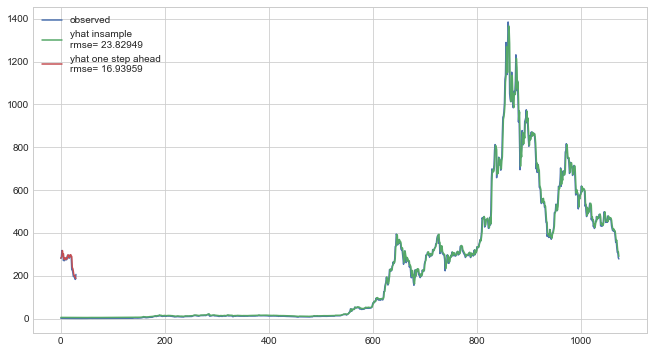

In [124]:
fig, ax = plt.subplots(figsize=(11,6))

plt.plot(train_obs, label="observed", c=colors[0])
plt.plot(observed, c=colors[0])
plt.plot(train_preds, label='yhat insample\nrmse= {:.5f}'.format(train_rmse), c=colors[1])
plt.plot(test_preds, label='yhat one step ahead\nrmse= {:.5f}'.format(test_rmse), c=colors[2])
plt.legend()
plt.show()